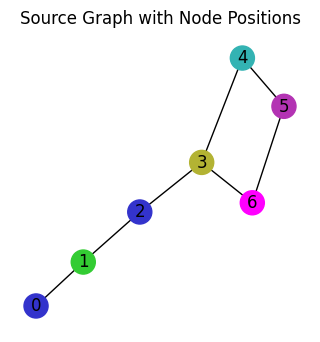

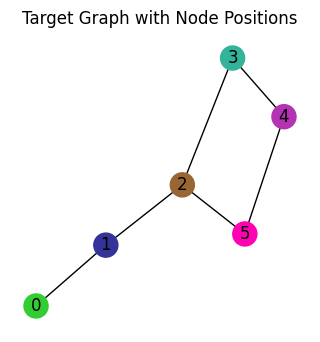

torch.Size([3, 7]) torch.Size([3, 6]) torch.Size([7, 7]) torch.Size([6, 6])
tensor([[0.0000, 0.0719, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1571, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1242, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1459, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.1520, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1530, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1478]])
tensor(0.9519)


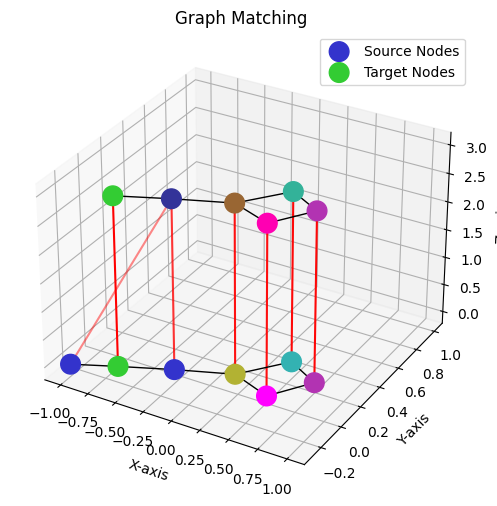

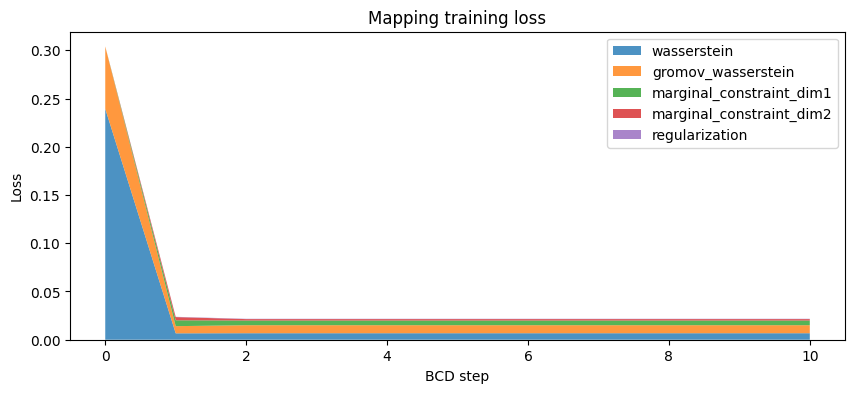

In [45]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from fugw_solver.solver import solver
import torch
from collections import defaultdict

###CREATE GRAPHS 

source_adjacency_matrix = np.array([[0, 1, 0, 0, 0, 0, 0],
                             [1, 0, 1, 0, 0, 0, 0],
                             [0, 1, 0, 1, 0, 0, 0],
                             [0, 0, 1, 0, 1, 0, 1],
                             [0, 0, 0, 1, 0, 1, 0],
                             [0, 0, 0, 0, 1, 0, 1],
                             [0, 0, 0, 1, 0, 1, 0]])

n_points_source = len(source_adjacency_matrix)

source_graph = nx.Graph(source_adjacency_matrix)

source_geometry = nx.floyd_warshall_numpy(source_graph)

source_locations = nx.spring_layout(source_graph)

source_node_colors = {
    0: (0.2, 0.2, 0.8),  # Red
    1: (0.2, 0.8, 0.2),  # Green
    2: (0.2, 0.2, 0.8),  # Blue
    3: (0.7, 0.7, 0.2),  # Yellow
    4: (0.2, 0.7, 0.7),  # Cyan
    5: (0.7, 0.2, 0.7),   # Magenta
    6: (1, 0, 1)
}
source_features = list(source_node_colors.values())

nx.set_node_attributes(source_graph, source_node_colors, 'color')
source_node_colors = nx.get_node_attributes(source_graph, 'color').values()

plt.figure(figsize=(3, 3))
nx.draw(source_graph, source_locations, node_color=list(source_node_colors), with_labels=True)
plt.title('Source Graph with Node Positions')
plt.show()

target_node_colors = {
    0: (0.2, 0.8, 0.2),  # Green
    1: (0.2, 0.2, 0.6),  # Blue
    2: (0.6, 0.4, 0.2),  # Yellow
    3: (0.2, 0.7, 0.6),  # Cyan
    4: (0.7, 0.2, 0.7),   # Magenta
    5: (1, 0, 0.7)
}
target_features = list(target_node_colors.values())

target_graph = source_graph.copy()

target_graph.remove_node(0)

mapping = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}

target_graph = nx.relabel_nodes(target_graph, mapping)

nx.set_node_attributes(target_graph, target_node_colors, 'color')

target_node_colors = nx.get_node_attributes(target_graph, 'color').values()

target_geometry = nx.floyd_warshall_numpy(target_graph)

source_locations_without_first = source_locations.copy()

source_locations_without_first.pop(0, None)

target_locations = {new_node: source_locations_without_first[old_node] for new_node, old_node in enumerate(source_locations_without_first.keys())}

plt.figure(figsize=(3, 3))
nx.draw(target_graph, target_locations, node_color=list(target_node_colors), with_labels=True)
plt.title('Target Graph with Node Positions')
plt.show()

###CREATE GEOMETRY AND FEATURES

source_features = torch.tensor(source_features, dtype=torch.float32)
target_features = torch.tensor(target_features, dtype=torch.float32)

source_features_normalized = source_features / torch.linalg.norm(source_features, dim=1).reshape(-1, 1)
target_features_normalized = target_features / torch.linalg.norm(target_features, dim=1).reshape(-1, 1)

source_features_normalized = torch.transpose(source_features_normalized, 0, 1)
target_features_normalized = torch.transpose(target_features_normalized, 0, 1)

source_geometry = torch.tensor(source_geometry, dtype=torch.float32) / 5
target_geometry = torch.tensor(target_geometry, dtype=torch.float32) / 5

w_s = torch.ones(source_features_normalized.shape[1], device='cpu') / source_features_normalized.shape[1]
w_t = torch.ones(target_features_normalized.shape[1], device='cpu') / target_features_normalized.shape[1]

print(source_features_normalized.shape, target_features_normalized.shape, source_geometry.shape, target_geometry.shape)

###SOLVE

alpha = 0.5
rho = 0.1
eps = 1e-4
mapping = solver(alpha=alpha, rho=rho, eps=eps, 
    source_features=source_features_normalized,
    target_features=target_features_normalized,
    source_geometry=source_geometry,
    target_geometry=target_geometry,
    device='cpu',
    w_s=w_s,
    w_t=w_t
)

P = mapping[0]

print(P)
print(P.sum())

###PLOT

from mpl_toolkits.mplot3d.art3d import Line3DCollection

def plot_graph_matching_3D(source_locations, target_locations, source_graph, target_graph, P, distance_between_graphs):
    pos_source = source_locations
    pos_target = target_locations

    pos_source = np.array([[pos_source[key][0], pos_source[key][1], 0] for key in pos_source.keys()])
    pos_target = np.array([[pos_target[key][0], pos_target[key][1], distance_between_graphs] for key in pos_target.keys()])
    
    edges_source = list(source_graph.edges())
    segments_source = [[pos_source[edge[0]].tolist(), pos_source[edge[1]].tolist()] for edge in edges_source]
    
    edges_target = list(target_graph.edges())
    segments_target = [[pos_target[edge[0]].tolist(), pos_target[edge[1]].tolist()] for edge in edges_target]
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')  
    
    line_segments_source = Line3DCollection(segments_source, colors="black", lw=1, zorder=1)
    ax.add_collection(line_segments_source)  
    ax.scatter(pos_source[:, 0], pos_source[:, 1], pos_source[:, 2], color=source_features.tolist(), s=200, label='Source Nodes', depthshade=False)
    
    line_segments_target = Line3DCollection(segments_target, colors="black", lw=1, zorder=1)
    ax.add_collection(line_segments_target)  
    ax.scatter(pos_target[:, 0], pos_target[:, 1], pos_target[:, 2], color=target_features.tolist(), s=200, label='Target Nodes', depthshade=False)

    transport_matrix = P / P.max()

    for i in range(transport_matrix.shape[0]):
        for j in range(transport_matrix.shape[1]):
            x1, y1, z1 = pos_source[i]
            x2, y2, z2 = pos_target[j]
            ax.plot([x1, x2], [y1, y2], [z1, z2], color='red', alpha=float(transport_matrix[i, j]))

    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title('Graph Matching')
    ax.legend()
    plt.show()

%matplotlib inline
plot_graph_matching_3D(source_locations, target_locations, source_graph, target_graph, P, 3)

loss_ls = mapping[1]
loss = defaultdict(list)
for l in loss_ls:
    for k,v in l.items():
        loss[k].append(v)

fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title("Mapping training loss")
ax.set_ylabel("Loss")
ax.set_xlabel("BCD step")
ax.stackplot(
    np.arange(len(loss_ls)),
    [
        (1 - alpha) * np.array(loss["wasserstein"]),
        alpha * np.array(loss["gromov_wasserstein"]),
        rho * np.array(loss["marginal_constraint_dim1"]),
        rho * np.array(loss["marginal_constraint_dim2"]),
        eps * np.array(loss["regularization"]),
    ],
    labels=[
        "wasserstein",
        "gromov_wasserstein",
        "marginal_constraint_dim1",
        "marginal_constraint_dim2",
        "regularization",
    ],
    alpha=0.8,
)
ax.legend()
plt.show()

# BALANCED VS UNBALANCED

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from fugw_solver.solver import solver
import torch
from collections import defaultdict
import imageio
import os

###CREATE GRAPHS 

source_adjacency_matrix = np.array([[0, 1, 0, 0, 0, 0, 0],
                             [1, 0, 1, 0, 0, 0, 0],
                             [0, 1, 0, 1, 0, 0, 0],
                             [0, 0, 1, 0, 1, 0, 1],
                             [0, 0, 0, 1, 0, 1, 0],
                             [0, 0, 0, 0, 1, 0, 1],
                             [0, 0, 0, 1, 0, 1, 0]])

n_points_source = len(source_adjacency_matrix)

source_graph = nx.Graph(source_adjacency_matrix)

source_geometry = nx.floyd_warshall_numpy(source_graph)

source_locations = nx.spring_layout(source_graph)

source_node_colors = {
    0: (0.2, 0.2, 0.8),  # Red
    1: (0.2, 0.8, 0.2),  # Green
    2: (0.2, 0.2, 0.8),  # Blue
    3: (0.7, 0.7, 0.2),  # Yellow
    4: (0.2, 0.7, 0.7),  # Cyan
    5: (0.7, 0.2, 0.7),   # Magenta
    6: (1, 0, 1)
}
source_features = list(source_node_colors.values())

nx.set_node_attributes(source_graph, source_node_colors, 'color')
source_node_colors = nx.get_node_attributes(source_graph, 'color').values()

target_node_colors = {
    0: (0.2, 0.8, 0.2),  # Green
    1: (0.2, 0.2, 0.6),  # Blue
    2: (0.6, 0.4, 0.2),  # Yellow
    3: (0.2, 0.7, 0.6),  # Cyan
    4: (0.7, 0.2, 0.7),   # Magenta
    5: (1, 0, 0.7)
}
target_features = list(target_node_colors.values())

target_graph = source_graph.copy()

target_graph.remove_node(0)

mapping = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}

target_graph = nx.relabel_nodes(target_graph, mapping)

nx.set_node_attributes(target_graph, target_node_colors, 'color')

target_node_colors = nx.get_node_attributes(target_graph, 'color').values()

target_geometry = nx.floyd_warshall_numpy(target_graph)

source_locations_without_first = source_locations.copy()

source_locations_without_first.pop(0, None)

target_locations = {new_node: source_locations_without_first[old_node] for new_node, old_node in enumerate(source_locations_without_first.keys())}

###CREATE GEOMETRY AND FEATURES

source_features = torch.tensor(source_features, dtype=torch.float32)
target_features = torch.tensor(target_features, dtype=torch.float32)

source_features_normalized = source_features / torch.linalg.norm(source_features, dim=1).reshape(-1, 1)
target_features_normalized = target_features / torch.linalg.norm(target_features, dim=1).reshape(-1, 1)

source_features_normalized = torch.transpose(source_features_normalized, 0, 1)
target_features_normalized = torch.transpose(target_features_normalized, 0, 1)

source_geometry = torch.tensor(source_geometry, dtype=torch.float32) / 5
target_geometry = torch.tensor(target_geometry, dtype=torch.float32) / 5

w_s = torch.ones(source_features_normalized.shape[1], device='cpu') / source_features_normalized.shape[1]
w_t = torch.ones(target_features_normalized.shape[1], device='cpu') / target_features_normalized.shape[1]


###PLOT

from mpl_toolkits.mplot3d.art3d import Line3DCollection

def plot_graph_matching_3D(source_locations, target_locations, source_graph, target_graph, P, distance_between_graphs, rho):
    pos_source = source_locations
    pos_target = target_locations

    pos_source = np.array([[pos_source[key][0], pos_source[key][1], 0] for key in pos_source.keys()])
    pos_target = np.array([[pos_target[key][0], pos_target[key][1], distance_between_graphs] for key in pos_target.keys()])
    
    edges_source = list(source_graph.edges())
    segments_source = [[pos_source[edge[0]].tolist(), pos_source[edge[1]].tolist()] for edge in edges_source]
    
    edges_target = list(target_graph.edges())
    segments_target = [[pos_target[edge[0]].tolist(), pos_target[edge[1]].tolist()] for edge in edges_target]
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')  
    
    line_segments_source = Line3DCollection(segments_source, colors="black", lw=1, zorder=1)
    ax.add_collection(line_segments_source)  
    ax.scatter(pos_source[:, 0], pos_source[:, 1], pos_source[:, 2], color=source_features.tolist(), s=200, depthshade=False)
    
    line_segments_target = Line3DCollection(segments_target, colors="black", lw=1, zorder=1)
    ax.add_collection(line_segments_target)  
    ax.scatter(pos_target[:, 0], pos_target[:, 1], pos_target[:, 2], color=target_features.tolist(), s=200, depthshade=False)

    transport_matrix = P / P.max()

    for i in range(transport_matrix.shape[0]):
        for j in range(transport_matrix.shape[1]):
            x1, y1, z1 = pos_source[i]
            x2, y2, z2 = pos_target[j]
            ax.plot([x1, x2], [y1, y2], [z1, z2], color='red', alpha=float(transport_matrix[i, j]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_title(f'Graph Matching, rho={rho}')
    ax.legend()
    plt.show()
    return fig


def save_frame_as_image(frame_number, fig, file_path):
    file_path = f"{file_path}_{frame_number:03d}.png"
    fig.savefig(file_path)
    plt.close()

os.makedirs("frames", exist_ok=True)

rho_values = [0.001 * 2**(i/10) for i in range(100)]

for frame_number, rho in enumerate(rho_values):
    alpha = 0.5
    eps = 1e-4
    mapping = solver(
        alpha=alpha,
        rho=rho,
        eps=eps,
        source_features=source_features_normalized,
        target_features=target_features_normalized,
        source_geometry=source_geometry,
        target_geometry=target_geometry,
        device='cpu',
        w_s=w_s,
        w_t=w_t
    )
    P = mapping[0]

    fig = plot_graph_matching_3D(source_locations, target_locations, source_graph, target_graph, P, 3, rho)
    
    save_frame_as_image(frame_number, fig, "frames/graph_matching_frame")

image_paths = ["frames/graph_matching_frame_{:03d}.png".format(i) for i in range(len(rho_list))]
images = [imageio.imread(image_path) for image_path in image_paths]
imageio.mimsave('graph_matching_animation.gif', images)

for image_path in image_paths:
    os.remove(image_path)

#os.rmdir("frames")



In [65]:
image_paths = ["frames/graph_matching_frame_{:03d}.png".format(i) for i in range(94)]
images = [imageio.imread(image_path) for image_path in image_paths]
imageio.mimsave('unbalanced.gif', images)

/var/folders/1b/w7rf9bbd25j4zyf1j6_lhyq40000gn/T/ipykernel_91124/3227670119.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(image_path) for image_path in image_paths]


# WASSERSTEIN VS GROMOV

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


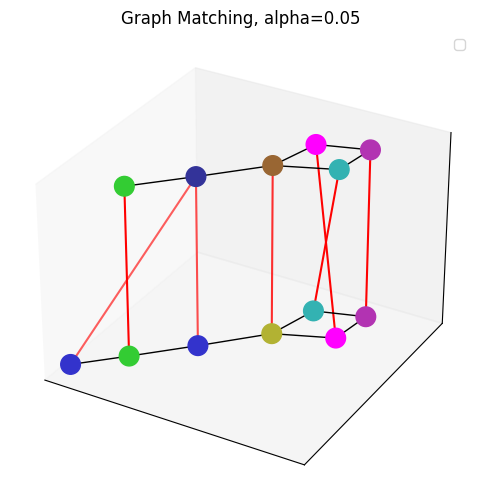

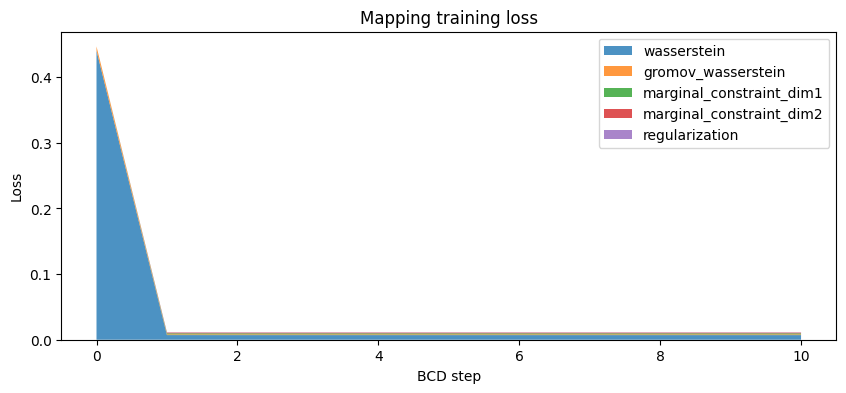

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


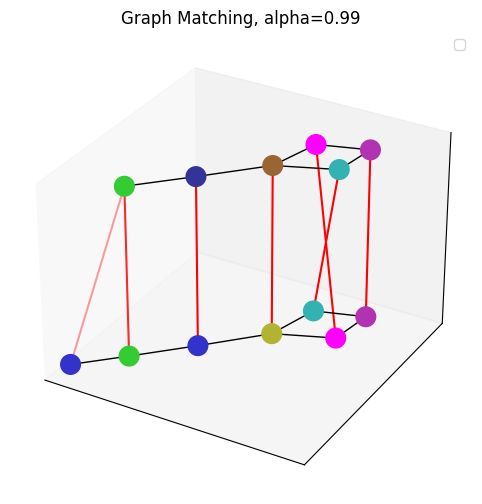

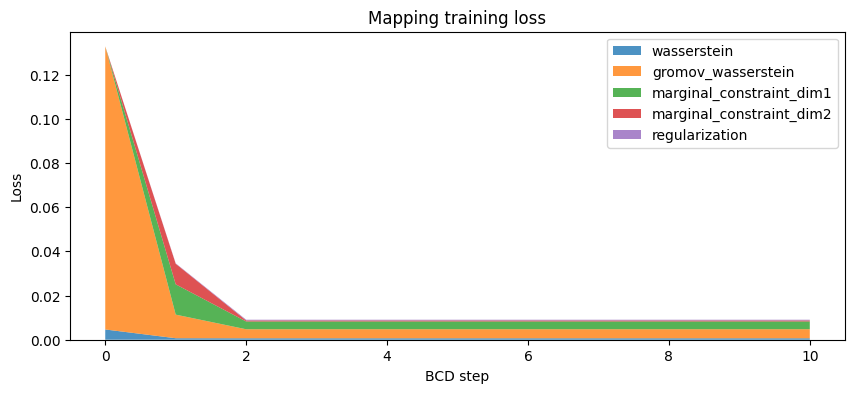

In [76]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from fugw_solver.solver import solver
import torch
from collections import defaultdict

###CREATE GRAPHS 

source_adjacency_matrix = np.array([[0, 1, 0, 0, 0, 0, 0],
                             [1, 0, 1, 0, 0, 0, 0],
                             [0, 1, 0, 1, 0, 0, 0],
                             [0, 0, 1, 0, 1, 0, 1],
                             [0, 0, 0, 1, 0, 1, 0],
                             [0, 0, 0, 0, 1, 0, 1],
                             [0, 0, 0, 1, 0, 1, 0]])

n_points_source = len(source_adjacency_matrix)

source_graph = nx.Graph(source_adjacency_matrix)

source_geometry = nx.floyd_warshall_numpy(source_graph)

source_locations = nx.spring_layout(source_graph)

source_node_colors = {
    0: (0.2, 0.2, 0.8),  # Red
    1: (0.2, 0.8, 0.2),  # Green
    2: (0.2, 0.2, 0.8),  # Blue
    3: (0.7, 0.7, 0.2),  # Yellow
    4: (0.2, 0.7, 0.7),  # Cyan
    5: (0.7, 0.2, 0.7),   # Magenta
    6: (1, 0, 1)
}
source_features = list(source_node_colors.values())

nx.set_node_attributes(source_graph, source_node_colors, 'color')
source_node_colors = nx.get_node_attributes(source_graph, 'color').values()

target_node_colors = {
    0: (0.2, 0.8, 0.2),  # Green
    1: (0.2, 0.2, 0.6),  # Blue
    2: (0.6, 0.4, 0.2),  # Yellow
    3: (1, 0, 1),
    4: (0.7, 0.2, 0.7),   # Magenta
    5: (0.2, 0.7, 0.7)
}
target_features = list(target_node_colors.values())

target_graph = source_graph.copy()

target_graph.remove_node(0)

mapping = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}

target_graph = nx.relabel_nodes(target_graph, mapping)

nx.set_node_attributes(target_graph, target_node_colors, 'color')

target_node_colors = nx.get_node_attributes(target_graph, 'color').values()

target_geometry = nx.floyd_warshall_numpy(target_graph)

source_locations_without_first = source_locations.copy()

source_locations_without_first.pop(0, None)

target_locations = {new_node: source_locations_without_first[old_node] for new_node, old_node in enumerate(source_locations_without_first.keys())}

###CREATE GEOMETRY AND FEATURES

source_features = torch.tensor(source_features, dtype=torch.float32)
target_features = torch.tensor(target_features, dtype=torch.float32)

source_features_normalized = source_features / torch.linalg.norm(source_features, dim=1).reshape(-1, 1)
target_features_normalized = target_features / torch.linalg.norm(target_features, dim=1).reshape(-1, 1)

source_features_normalized = torch.transpose(source_features_normalized, 0, 1)
target_features_normalized = torch.transpose(target_features_normalized, 0, 1)

source_geometry = torch.tensor(source_geometry, dtype=torch.float32) / 5
target_geometry = torch.tensor(target_geometry, dtype=torch.float32) / 5

w_s = torch.ones(source_features_normalized.shape[1], device='cpu') / source_features_normalized.shape[1]
w_t = torch.ones(target_features_normalized.shape[1], device='cpu') / target_features_normalized.shape[1]

###PLOT

from mpl_toolkits.mplot3d.art3d import Line3DCollection

def plot_graph_matching_3D(source_locations, target_locations, source_graph, target_graph, P, distance_between_graphs, alpha):
    pos_source = source_locations
    pos_target = target_locations

    pos_source = np.array([[pos_source[key][0], pos_source[key][1], 0] for key in pos_source.keys()])
    pos_target = np.array([[pos_target[key][0], pos_target[key][1], distance_between_graphs] for key in pos_target.keys()])
    
    edges_source = list(source_graph.edges())
    segments_source = [[pos_source[edge[0]].tolist(), pos_source[edge[1]].tolist()] for edge in edges_source]
    
    edges_target = list(target_graph.edges())
    segments_target = [[pos_target[edge[0]].tolist(), pos_target[edge[1]].tolist()] for edge in edges_target]
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')  
    
    line_segments_source = Line3DCollection(segments_source, colors="black", lw=1, zorder=1)
    ax.add_collection(line_segments_source)  
    ax.scatter(pos_source[:, 0], pos_source[:, 1], pos_source[:, 2], color=source_features.tolist(), s=200, depthshade=False)
    
    line_segments_target = Line3DCollection(segments_target, colors="black", lw=1, zorder=1)
    ax.add_collection(line_segments_target)  
    ax.scatter(pos_target[:, 0], pos_target[:, 1], pos_target[:, 2], color=target_features.tolist(), s=200, depthshade=False)

    transport_matrix = P / P.max()

    for i in range(transport_matrix.shape[0]):
        for j in range(transport_matrix.shape[1]):
            x1, y1, z1 = pos_source[i]
            x2, y2, z2 = pos_target[j]
            ax.plot([x1, x2], [y1, y2], [z1, z2], color='red', alpha=float(transport_matrix[i, j]))

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_title(f'Graph Matching, alpha={alpha}')
    ax.legend()
    plt.show()


for alpha in [0.05, 0.99]:
    
    rho = 0.05
    eps = 1e-4
    mapping = solver(alpha=alpha, rho=rho, eps=eps, 
        source_features=source_features_normalized,
        target_features=target_features_normalized,
        source_geometry=source_geometry,
        target_geometry=target_geometry,
        device='cpu',
        w_s=w_s,
        w_t=w_t
    )
    
    P = mapping[0]
    
    %matplotlib inline
    plot_graph_matching_3D(source_locations, target_locations, source_graph, target_graph, P, 3, alpha)

    loss_ls = mapping[1]
    loss = defaultdict(list)
    for l in loss_ls:
        for k,v in l.items():
            loss[k].append(v)
    
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.set_title("Mapping training loss")
    ax.set_ylabel("Loss")
    ax.set_xlabel("BCD step")
    ax.stackplot(
        np.arange(len(loss_ls)),
        [
            (1 - alpha) * np.array(loss["wasserstein"]),
            alpha * np.array(loss["gromov_wasserstein"]),
            rho * np.array(loss["marginal_constraint_dim1"]),
            rho * np.array(loss["marginal_constraint_dim2"]),
            eps * np.array(loss["regularization"]),
        ],
        labels=[
            "wasserstein",
            "gromov_wasserstein",
            "marginal_constraint_dim1",
            "marginal_constraint_dim2",
            "regularization",
        ],
        alpha=0.8,
    )
    ax.legend()
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


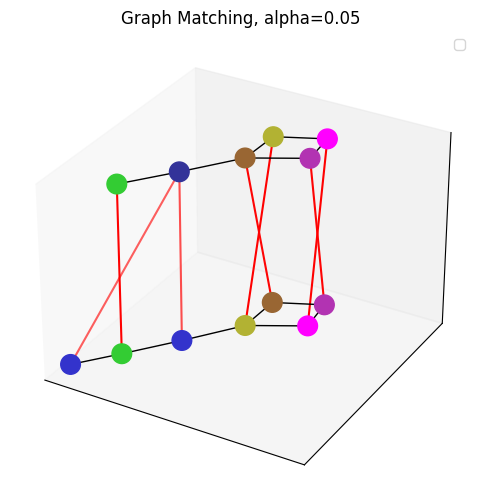

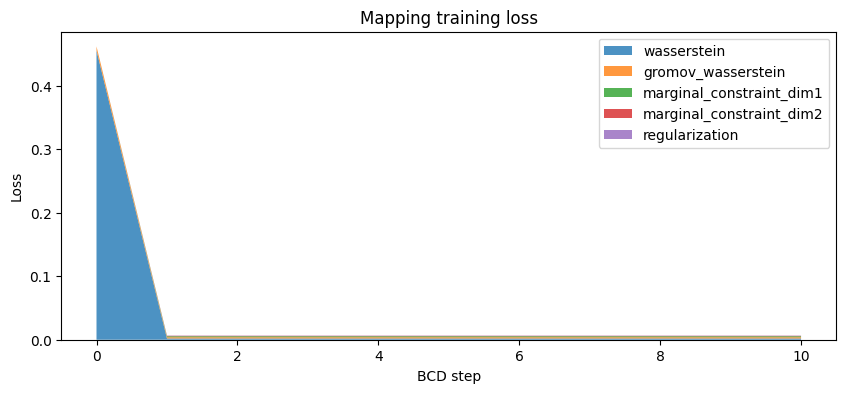

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


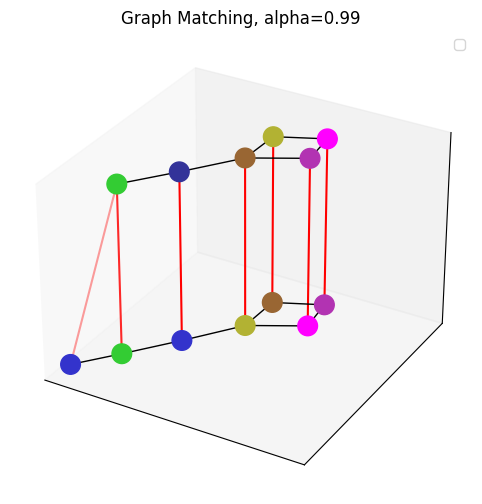

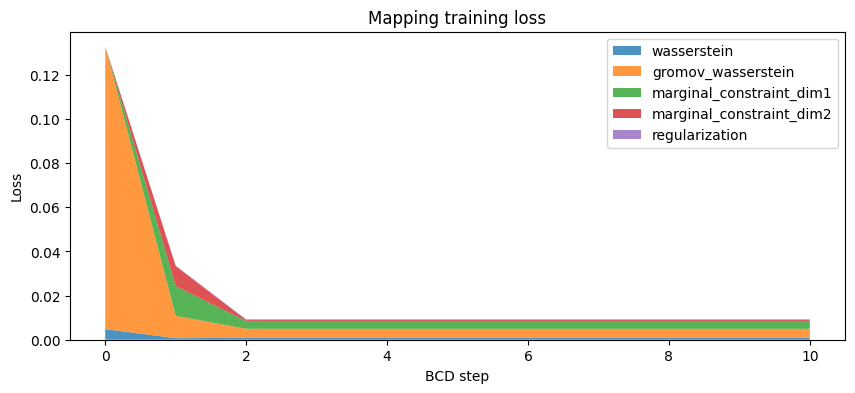

In [60]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from fugw_solver.solver import solver
import torch
from collections import defaultdict

###CREATE GRAPHS 

source_adjacency_matrix = np.array([[0, 1, 0, 0, 0, 0, 0],
                             [1, 0, 1, 0, 0, 0, 0],
                             [0, 1, 0, 1, 0, 0, 0],
                             [0, 0, 1, 0, 1, 0, 1],
                             [0, 0, 0, 1, 0, 1, 0],
                             [0, 0, 0, 0, 1, 0, 1],
                             [0, 0, 0, 1, 0, 1, 0]])

n_points_source = len(source_adjacency_matrix)

source_graph = nx.Graph(source_adjacency_matrix)

source_geometry = nx.floyd_warshall_numpy(source_graph)

source_locations = nx.spring_layout(source_graph)

source_node_colors = {
    0: (0.2, 0.2, 0.8), 
    1: (0.2, 0.8, 0.2), 
    2: (0.2, 0.2, 0.8), 
    3: (0.7, 0.7, 0.2), 
    4: (0.6, 0.4, 0.2), 
    5: (0.7, 0.2, 0.7),  
    6: (1, 0, 1)
}
source_features = list(source_node_colors.values())

nx.set_node_attributes(source_graph, source_node_colors, 'color')
source_node_colors = nx.get_node_attributes(source_graph, 'color').values()

target_node_colors = {
    0: (0.2, 0.8, 0.2), 
    1: (0.2, 0.2, 0.6),  
    2: (0.6, 0.4, 0.2),  
    3: (0.7, 0.7, 0.2),  
    4: (1, 0, 1),   
    5: (0.7, 0.2, 0.7)
}
target_features = list(target_node_colors.values())

target_graph = source_graph.copy()

target_graph.remove_node(0)

mapping = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}

target_graph = nx.relabel_nodes(target_graph, mapping)

nx.set_node_attributes(target_graph, target_node_colors, 'color')

target_node_colors = nx.get_node_attributes(target_graph, 'color').values()

target_geometry = nx.floyd_warshall_numpy(target_graph)

source_locations_without_first = source_locations.copy()

source_locations_without_first.pop(0, None)

target_locations = {new_node: source_locations_without_first[old_node] for new_node, old_node in enumerate(source_locations_without_first.keys())}

###CREATE GEOMETRY AND FEATURES

source_features = torch.tensor(source_features, dtype=torch.float32)
target_features = torch.tensor(target_features, dtype=torch.float32)

source_features_normalized = source_features / torch.linalg.norm(source_features, dim=1).reshape(-1, 1)
target_features_normalized = target_features / torch.linalg.norm(target_features, dim=1).reshape(-1, 1)

source_features_normalized = torch.transpose(source_features_normalized, 0, 1)
target_features_normalized = torch.transpose(target_features_normalized, 0, 1)

source_geometry = torch.tensor(source_geometry, dtype=torch.float32) / 5
target_geometry = torch.tensor(target_geometry, dtype=torch.float32) / 5

w_s = torch.ones(source_features_normalized.shape[1], device='cpu') / source_features_normalized.shape[1]
w_t = torch.ones(target_features_normalized.shape[1], device='cpu') / target_features_normalized.shape[1]

###PLOT

from mpl_toolkits.mplot3d.art3d import Line3DCollection

def plot_graph_matching_3D(source_locations, target_locations, source_graph, target_graph, P, distance_between_graphs, alpha):
    pos_source = source_locations
    pos_target = target_locations

    pos_source = np.array([[pos_source[key][0], pos_source[key][1], 0] for key in pos_source.keys()])
    pos_target = np.array([[pos_target[key][0], pos_target[key][1], distance_between_graphs] for key in pos_target.keys()])
    
    edges_source = list(source_graph.edges())
    segments_source = [[pos_source[edge[0]].tolist(), pos_source[edge[1]].tolist()] for edge in edges_source]
    
    edges_target = list(target_graph.edges())
    segments_target = [[pos_target[edge[0]].tolist(), pos_target[edge[1]].tolist()] for edge in edges_target]
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')  
    
    line_segments_source = Line3DCollection(segments_source, colors="black", lw=1, zorder=1)
    ax.add_collection(line_segments_source)  
    ax.scatter(pos_source[:, 0], pos_source[:, 1], pos_source[:, 2], color=source_features.tolist(), s=200, depthshade=False)
    
    line_segments_target = Line3DCollection(segments_target, colors="black", lw=1, zorder=1)
    ax.add_collection(line_segments_target)  
    ax.scatter(pos_target[:, 0], pos_target[:, 1], pos_target[:, 2], color=target_features.tolist(), s=200, depthshade=False)

    transport_matrix = P / P.max()

    for i in range(transport_matrix.shape[0]):
        for j in range(transport_matrix.shape[1]):
            x1, y1, z1 = pos_source[i]
            x2, y2, z2 = pos_target[j]
            ax.plot([x1, x2], [y1, y2], [z1, z2], color='red', alpha=float(transport_matrix[i, j]))

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_title(f'Graph Matching, alpha={alpha}')
    ax.legend()
    plt.show()


for alpha in [0.05, 0.99]:
    
    rho = 0.05
    eps = 1e-4
    mapping = solver(alpha=alpha, rho=rho, eps=eps, 
        source_features=source_features_normalized,
        target_features=target_features_normalized,
        source_geometry=source_geometry,
        target_geometry=target_geometry,
        device='cpu',
        w_s=w_s,
        w_t=w_t
    )
    
    P = mapping[0]
    
    %matplotlib inline
    plot_graph_matching_3D(source_locations, target_locations, source_graph, target_graph, P, 3, alpha)

    loss_ls = mapping[1]
    loss = defaultdict(list)
    for l in loss_ls:
        for k,v in l.items():
            loss[k].append(v)
    
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.set_title("Mapping training loss")
    ax.set_ylabel("Loss")
    ax.set_xlabel("BCD step")
    ax.stackplot(
        np.arange(len(loss_ls)),
        [
            (1 - alpha) * np.array(loss["wasserstein"]),
            alpha * np.array(loss["gromov_wasserstein"]),
            rho * np.array(loss["marginal_constraint_dim1"]),
            rho * np.array(loss["marginal_constraint_dim2"]),
            eps * np.array(loss["regularization"]),
        ],
        labels=[
            "wasserstein",
            "gromov_wasserstein",
            "marginal_constraint_dim1",
            "marginal_constraint_dim2",
            "regularization",
        ],
        alpha=0.8,
    )
    ax.legend()
    plt.show()


# Clustering

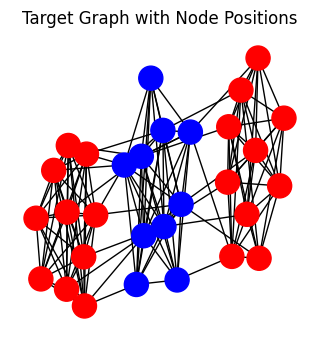

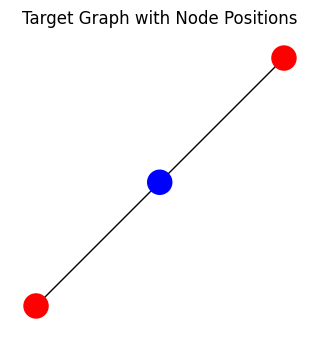

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


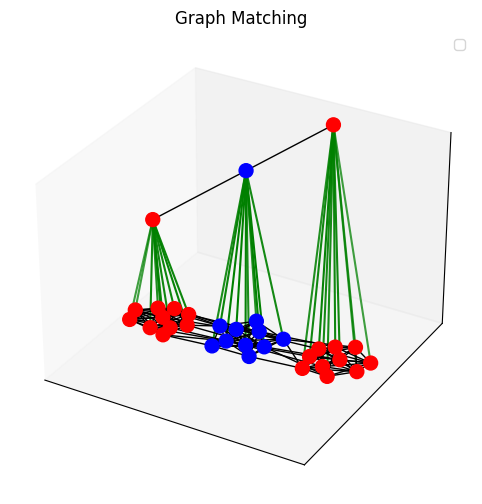

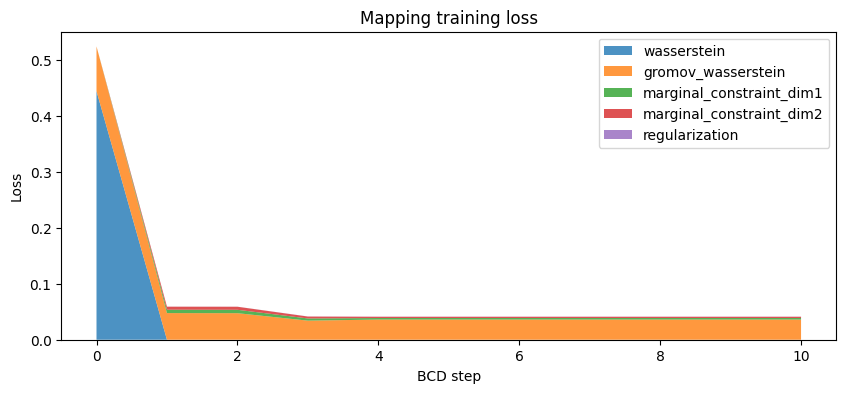

In [29]:
import numpy as np
import matplotlib.pylab as pl
from ot.gromov import entropic_semirelaxed_gromov_wasserstein, entropic_semirelaxed_fused_gromov_wasserstein, gromov_wasserstein, fused_gromov_wasserstein
import networkx as nx
from networkx.generators.community import stochastic_block_model as sbm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from fugw_solver.solver import solver
import torch
from collections import defaultdict

###CREATE GRAPHS

N3 = 30  # 3 communities
p3 = [[1., 0.1, 0.],
      [0.1, 0.95, 0.1],
      [0., 0.1, 0.9]]
G3 = sbm(seed=0, sizes=[N3 // 3, N3 // 3, N3 // 3], p=p3)
C3 = nx.to_numpy_array(G3)
h3 = np.ones(C3.shape[0]) / C3.shape[0]
weight_intra_G3 = 1.
weight_inter_G3 = 1.5

source_graph = nx.Graph()
part_G3 = [G3.nodes[i]['block'] for i in range(N3)]

source_node_colors = {}
for i in range(len(part_G3)):
    if part_G3[i] == 0 or part_G3[i] == 2:
        source_node_colors[i] = (1, 0, 0)
    else:
        source_node_colors[i] = (0, 0, 1)
        
source_features = list(source_node_colors.values())

nx.set_node_attributes(source_graph, source_node_colors, 'color')
source_node_colors = nx.get_node_attributes(source_graph, 'color').values()

for node in G3.nodes():
    source_graph.add_node(node)
for i, j in G3.edges():
    if part_G3[i] == part_G3[j]:
        source_graph.add_edge(i, j, weight=weight_intra_G3)
    else:
        source_graph.add_edge(i, j, weight=weight_inter_G3)

source_geometry = nx.floyd_warshall_numpy(source_graph)

source_locations = nx.spring_layout(source_graph)



target_adjacency_matrix = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])

target_graph = nx.Graph(target_adjacency_matrix)

target_features = [(1, 0, 0), (0, 0, 1), (1, 0, 0)]

target_node_colors = {i:target_features[i] for i in range(len(target_features))}

nx.set_node_attributes(target_graph, target_node_colors, 'color')
target_node_colors = nx.get_node_attributes(target_graph, 'color').values()

target_geometry = nx.floyd_warshall_numpy(target_graph)

target_locations = nx.spring_layout(target_graph)

###VISUALISE GRAPHS 

plt.figure(figsize=(3, 3))
nx.draw(source_graph, source_locations, node_color=source_features, with_labels=False)
plt.title('Target Graph with Node Positions')
plt.show()

plt.figure(figsize=(3, 3))
nx.draw(target_graph, target_locations, node_color=target_features, with_labels=False)
plt.title('Target Graph with Node Positions')
plt.show()

###CREATE GEOMETRY AND FEATURES

source_features = torch.tensor(source_features, dtype=torch.float32)
target_features = torch.tensor(target_features, dtype=torch.float32)

source_features_normalized = source_features / torch.linalg.norm(source_features, dim=1).reshape(-1, 1)
target_features_normalized = target_features / torch.linalg.norm(target_features, dim=1).reshape(-1, 1)

source_features_normalized = torch.transpose(source_features_normalized, 0, 1)
target_features_normalized = torch.transpose(target_features_normalized, 0, 1)

source_geometry = torch.tensor(source_geometry, dtype=torch.float32) / 5
target_geometry = torch.tensor(target_geometry, dtype=torch.float32) / 5

w_s = torch.ones(source_features_normalized.shape[1], device='cpu') / source_features_normalized.shape[1]
w_t = torch.ones(target_features_normalized.shape[1], device='cpu') / target_features_normalized.shape[1]


###SOLVE

alpha = 0.5
rho = 0.1
eps = 1e-4
mapping = solver(alpha=alpha, rho=rho, eps=eps, 
    source_features=source_features_normalized,
    target_features=target_features_normalized,
    source_geometry=source_geometry,
    target_geometry=target_geometry,
    device='cpu',
    w_s=w_s,
    w_t=w_t
)

P = mapping[0]

###PLOT

def plot_graph_matching_3D(source_locations, target_locations, source_graph, target_graph, P, distance_between_graphs):
    pos_source = source_locations
    pos_target = target_locations

    pos_source = np.array([[pos_source[key][0], pos_source[key][1], 0] for key in pos_source.keys()])
    pos_target = np.array([[pos_target[key][0], pos_target[key][1], distance_between_graphs] for key in pos_target.keys()])
    
    edges_source = list(source_graph.edges())
    segments_source = [[pos_source[edge[0]].tolist(), pos_source[edge[1]].tolist()] for edge in edges_source]
    
    edges_target = list(target_graph.edges())
    segments_target = [[pos_target[edge[0]].tolist(), pos_target[edge[1]].tolist()] for edge in edges_target]
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')  
    
    line_segments_source = Line3DCollection(segments_source, colors="black", lw=1, zorder=1)
    ax.add_collection(line_segments_source)  
    ax.scatter(pos_source[:, 0], pos_source[:, 1], pos_source[:, 2], color=source_features.tolist(), s=100, depthshade=False)
    
    line_segments_target = Line3DCollection(segments_target, colors="black", lw=1, zorder=1)
    ax.add_collection(line_segments_target)  
    ax.scatter(pos_target[:, 0], pos_target[:, 1], pos_target[:, 2], color=target_features.tolist(), s=100, depthshade=False)

    transport_matrix = P / P.max()

    for i in range(transport_matrix.shape[0]):
        for j in range(transport_matrix.shape[1]):
            x1, y1, z1 = pos_source[i]
            x2, y2, z2 = pos_target[j]
            ax.plot([x1, x2], [y1, y2], [z1, z2], color='green', alpha=float(transport_matrix[i, j]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_title('Graph Matching')
    ax.legend()
    plt.show()

%matplotlib inline
plot_graph_matching_3D(source_locations, target_locations, source_graph, target_graph, P, 3)

loss_ls = mapping[1]
loss = defaultdict(list)
for l in loss_ls:
    for k,v in l.items():
        loss[k].append(v)

fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title("Mapping training loss")
ax.set_ylabel("Loss")
ax.set_xlabel("BCD step")
ax.stackplot(
    np.arange(len(loss_ls)),
    [
        (1 - alpha) * np.array(loss["wasserstein"]),
        alpha * np.array(loss["gromov_wasserstein"]),
        rho * np.array(loss["marginal_constraint_dim1"]),
        rho * np.array(loss["marginal_constraint_dim2"]),
        eps * np.array(loss["regularization"]),
    ],
    labels=[
        "wasserstein",
        "gromov_wasserstein",
        "marginal_constraint_dim1",
        "marginal_constraint_dim2",
        "regularization",
    ],
    alpha=0.8,
)
ax.legend()
plt.show()

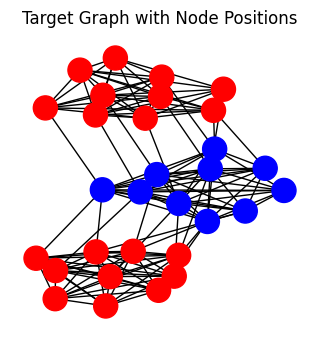

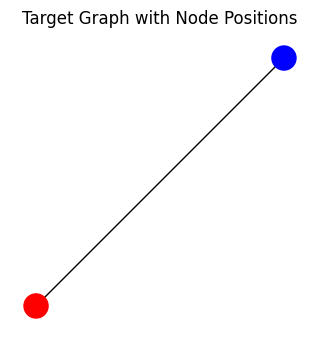

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Total transported mass : tensor(0.7061)


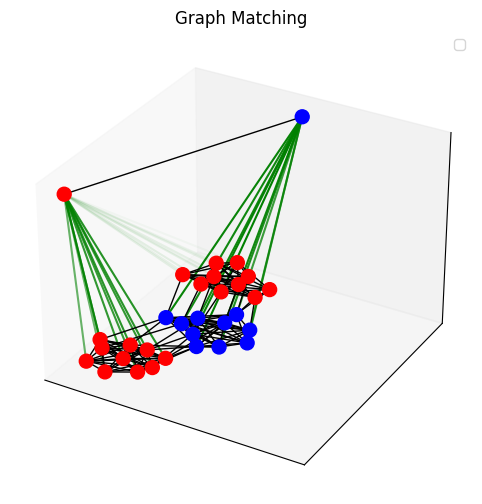

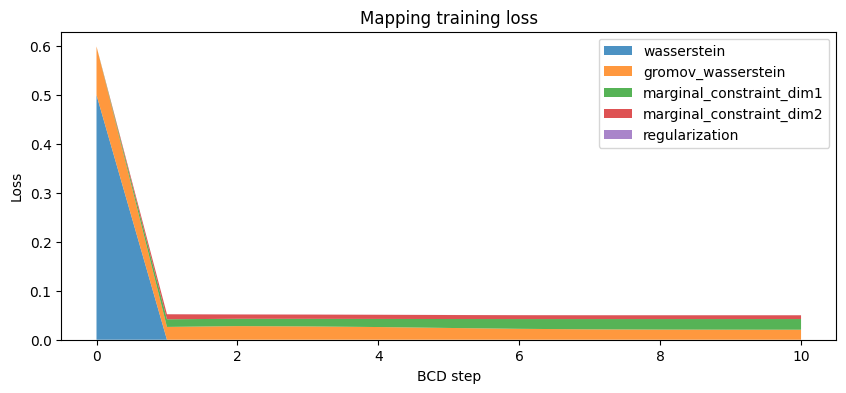

In [40]:
import numpy as np
import matplotlib.pylab as pl
from ot.gromov import entropic_semirelaxed_gromov_wasserstein, entropic_semirelaxed_fused_gromov_wasserstein, gromov_wasserstein, fused_gromov_wasserstein
import networkx as nx
from networkx.generators.community import stochastic_block_model as sbm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from fugw_solver.solver import solver
import torch
from collections import defaultdict

###CREATE GRAPHS

N3 = 30  # 3 communities
p3 = [[1., 0.1, 0.],
      [0.1, 0.95, 0.1],
      [0., 0.1, 0.9]]
G3 = sbm(seed=0, sizes=[N3 // 3, N3 // 3, N3 // 3], p=p3)
C3 = nx.to_numpy_array(G3)
h3 = np.ones(C3.shape[0]) / C3.shape[0]
weight_intra_G3 = 1.
weight_inter_G3 = 1.5

source_graph = nx.Graph()
part_G3 = [G3.nodes[i]['block'] for i in range(N3)]

source_node_colors = {}
for i in range(len(part_G3)):
    if part_G3[i] == 0 or part_G3[i] == 2:
        source_node_colors[i] = (1, 0, 0)
    else:
        source_node_colors[i] = (0, 0, 1)
        
source_features = list(source_node_colors.values())

nx.set_node_attributes(source_graph, source_node_colors, 'color')
source_node_colors = nx.get_node_attributes(source_graph, 'color').values()

for node in G3.nodes():
    source_graph.add_node(node)
for i, j in G3.edges():
    if part_G3[i] == part_G3[j]:
        source_graph.add_edge(i, j, weight=weight_intra_G3)
    else:
        source_graph.add_edge(i, j, weight=weight_inter_G3)

source_geometry = nx.floyd_warshall_numpy(source_graph)

source_locations = nx.spring_layout(source_graph)



target_adjacency_matrix = np.array([[0, 1], [1, 0]])

target_graph = nx.Graph(target_adjacency_matrix)

target_features = [(1, 0, 0), (0, 0, 1)]

target_node_colors = {i:target_features[i] for i in range(len(target_features))}

nx.set_node_attributes(target_graph, target_node_colors, 'color')
target_node_colors = nx.get_node_attributes(target_graph, 'color').values()

target_geometry = nx.floyd_warshall_numpy(target_graph)

target_locations = nx.spring_layout(target_graph)

###VISUALISE GRAPHS 

plt.figure(figsize=(3, 3))
nx.draw(source_graph, source_locations, node_color=source_features, with_labels=False)
plt.title('Target Graph with Node Positions')
plt.show()

plt.figure(figsize=(3, 3))
nx.draw(target_graph, target_locations, node_color=target_features, with_labels=False)
plt.title('Target Graph with Node Positions')
plt.show()

###CREATE GEOMETRY AND FEATURES

source_features = torch.tensor(source_features, dtype=torch.float32)
target_features = torch.tensor(target_features, dtype=torch.float32)

source_features_normalized = source_features / torch.linalg.norm(source_features, dim=1).reshape(-1, 1)
target_features_normalized = target_features / torch.linalg.norm(target_features, dim=1).reshape(-1, 1)

source_features_normalized = torch.transpose(source_features_normalized, 0, 1)
target_features_normalized = torch.transpose(target_features_normalized, 0, 1)

source_geometry = torch.tensor(source_geometry, dtype=torch.float32) / 5
target_geometry = torch.tensor(target_geometry, dtype=torch.float32) / 5

w_s = torch.ones(source_features_normalized.shape[1], device='cpu') / source_features_normalized.shape[1]
w_t = torch.ones(target_features_normalized.shape[1], device='cpu') / target_features_normalized.shape[1]


###SOLVE

alpha = 0.5
rho = 0.05
eps = 1e-4
mapping = solver(alpha=alpha, rho=rho, eps=eps, 
    source_features=source_features_normalized,
    target_features=target_features_normalized,
    source_geometry=source_geometry,
    target_geometry=target_geometry,
    device='cpu',
    w_s=w_s,
    w_t=w_t
)

P = mapping[0]

print("Total transported mass :", P.sum())

###PLOT

def plot_graph_matching_3D(source_locations, target_locations, source_graph, target_graph, P, distance_between_graphs):
    pos_source = source_locations
    pos_target = target_locations

    pos_source = np.array([[pos_source[key][0], pos_source[key][1], 0] for key in pos_source.keys()])
    pos_target = np.array([[pos_target[key][0], pos_target[key][1], distance_between_graphs] for key in pos_target.keys()])
    
    edges_source = list(source_graph.edges())
    segments_source = [[pos_source[edge[0]].tolist(), pos_source[edge[1]].tolist()] for edge in edges_source]
    
    edges_target = list(target_graph.edges())
    segments_target = [[pos_target[edge[0]].tolist(), pos_target[edge[1]].tolist()] for edge in edges_target]
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')  
    
    line_segments_source = Line3DCollection(segments_source, colors="black", lw=1, zorder=1)
    ax.add_collection(line_segments_source)  
    ax.scatter(pos_source[:, 0], pos_source[:, 1], pos_source[:, 2], color=source_features.tolist(), s=100, depthshade=False)
    
    line_segments_target = Line3DCollection(segments_target, colors="black", lw=1, zorder=1)
    ax.add_collection(line_segments_target)  
    ax.scatter(pos_target[:, 0], pos_target[:, 1], pos_target[:, 2], color=target_features.tolist(), s=100, depthshade=False)

    transport_matrix = P / P.max()

    for i in range(transport_matrix.shape[0]):
        for j in range(transport_matrix.shape[1]):
            x1, y1, z1 = pos_source[i]
            x2, y2, z2 = pos_target[j]
            ax.plot([x1, x2], [y1, y2], [z1, z2], color='green', alpha=float(transport_matrix[i, j]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_title('Graph Matching')
    ax.legend()
    plt.show()

%matplotlib inline
plot_graph_matching_3D(source_locations, target_locations, source_graph, target_graph, P, 3)

loss_ls = mapping[1]
loss = defaultdict(list)
for l in loss_ls:
    for k,v in l.items():
        loss[k].append(v)

fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title("Mapping training loss")
ax.set_ylabel("Loss")
ax.set_xlabel("BCD step")
ax.stackplot(
    np.arange(len(loss_ls)),
    [
        (1 - alpha) * np.array(loss["wasserstein"]),
        alpha * np.array(loss["gromov_wasserstein"]),
        rho * np.array(loss["marginal_constraint_dim1"]),
        rho * np.array(loss["marginal_constraint_dim2"]),
        eps * np.array(loss["regularization"]),
    ],
    labels=[
        "wasserstein",
        "gromov_wasserstein",
        "marginal_constraint_dim1",
        "marginal_constraint_dim2",
        "regularization",
    ],
    alpha=0.8,
)
ax.legend()
plt.show()

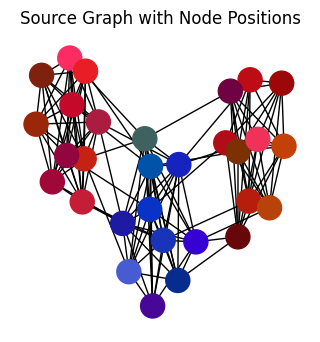

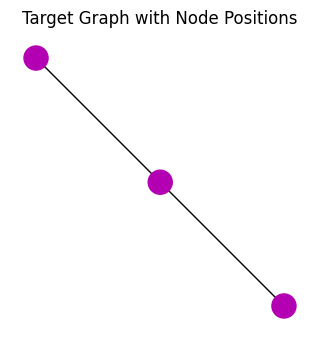

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Total transported mass : tensor(0.9362)


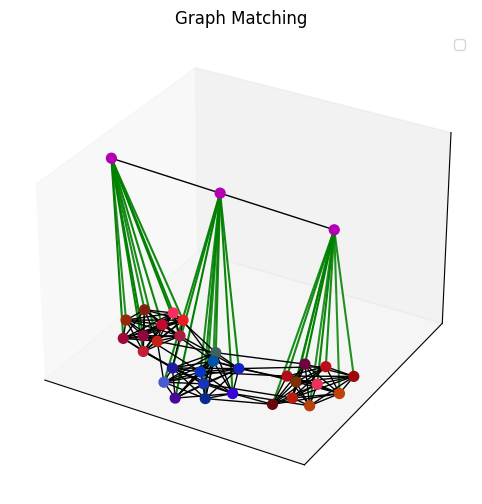

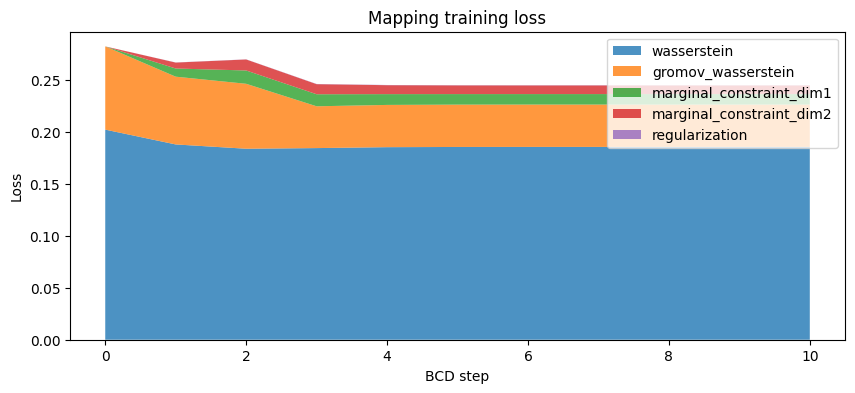

In [62]:
import numpy as np
import matplotlib.pylab as pl
from ot.gromov import entropic_semirelaxed_gromov_wasserstein, entropic_semirelaxed_fused_gromov_wasserstein, gromov_wasserstein, fused_gromov_wasserstein
import networkx as nx
from networkx.generators.community import stochastic_block_model as sbm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from fugw_solver.solver import solver
import torch
from collections import defaultdict
import math

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

def plt_scatter(locations, colours):
    x = []
    y = []
    for value in locations.values():
        x.append(value[0])
        y.append(value[1])
    plt.scatter(x,y,c=colours)
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.show()

def angle(vector1, vector2):
    """ Returns the angle in radians between given vectors"""
    v1_u = unit_vector(vector1)
    v2_u = unit_vector(vector2)
    minor = np.linalg.det(
        np.stack((v1_u[-2:], v2_u[-2:]))
    )
    if minor == 0:
        raise NotImplementedError('Too odd vectors =(')
    return -np.sign(minor) * np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def unit_vector(vector):
    """ Returns the unit vector of the vector"""
    return vector / np.linalg.norm(vector)


###CREATE GRAPHS

N3 = 30  # 3 communities
p3 = [[1., 0.1, 0.],
      [0.1, 0.95, 0.1],
      [0., 0.1, 0.9]]
G3 = sbm(seed=0, sizes=[N3 // 3, N3 // 3, N3 // 3], p=p3)
C3 = nx.to_numpy_array(G3)
h3 = np.ones(C3.shape[0]) / C3.shape[0]
weight_intra_G3 = 1.
weight_inter_G3 = 1.5

source_graph = nx.Graph()
part_G3 = [G3.nodes[i]['block'] for i in range(N3)]

source_node_colors = {}
for i in range(len(part_G3)):
    if part_G3[i] == 0:
        source_node_colors[i] = (min(0.7 + 0.2 * np.random.randn(), 1), abs(0.2 * np.random.randn()), abs(0.2 * np.random.randn()))
    elif part_G3[i] == 1:
        source_node_colors[i] = (abs(0.2 * np.random.randn()), abs(0.2 * np.random.randn()), min(0.2 * np.random.randn() + 0.7, 1))
    else:
        source_node_colors[i] = (min(0.7 + 0.2 * np.random.randn(), 1), abs(0.2 * np.random.randn()), abs(0.2 * np.random.randn()))
        
source_features = list(source_node_colors.values())

nx.set_node_attributes(source_graph, source_node_colors, 'color')
source_node_colors = nx.get_node_attributes(source_graph, 'color').values()

for node in G3.nodes():
    source_graph.add_node(node)
for i, j in G3.edges():
    if part_G3[i] == part_G3[j]:
        source_graph.add_edge(i, j, weight=weight_intra_G3)
    else:
        source_graph.add_edge(i, j, weight=weight_inter_G3)

source_geometry = nx.floyd_warshall_numpy(source_graph)

source_locations = nx.spring_layout(source_graph)

mean_cluster_1 = np.mean(list(source_locations.values())[:10], axis=0)
mean_cluster_3 = np.mean(list(source_locations.values())[-10:], axis=0)

direction_source = mean_cluster_3 - mean_cluster_1

target_adjacency_matrix = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])

target_graph = nx.Graph(target_adjacency_matrix)

target_features = [(0.7, 0, 0.7), (0.7, 0, 0.7), (0.7, 0, 0.7)]

target_node_colors = {i:target_features[i] for i in range(len(target_features))}

nx.set_node_attributes(target_graph, target_node_colors, 'color')
target_node_colors = nx.get_node_attributes(target_graph, 'color').values()

target_geometry = nx.floyd_warshall_numpy(target_graph)

target_locations = nx.spring_layout(target_graph)

direction_target = list(target_locations.values())[-1] - list(target_locations.values())[0]

theta = angle(direction_source, direction_target)

origin = np.mean(list(target_locations.values()), axis=0)

for key, value in target_locations.items():
    target_locations[key] = rotate(origin, value, theta)
    




###VISUALISE GRAPHS 

plt.figure(figsize=(3, 3))
nx.draw(source_graph, source_locations, node_color=source_features, with_labels=False)
plt.title('Source Graph with Node Positions')
plt.show()

plt.figure(figsize=(3, 3))
nx.draw(target_graph, target_locations, node_color=target_features, with_labels=False)
plt.title('Target Graph with Node Positions')
plt.show()

###CREATE GEOMETRY AND FEATURES

source_features = torch.tensor(source_features, dtype=torch.float32)
target_features = torch.tensor(target_features, dtype=torch.float32)

source_features_normalized = source_features / torch.linalg.norm(source_features, dim=1).reshape(-1, 1)
target_features_normalized = target_features / torch.linalg.norm(target_features, dim=1).reshape(-1, 1)

source_features_normalized = torch.transpose(source_features_normalized, 0, 1)
target_features_normalized = torch.transpose(target_features_normalized, 0, 1)

source_geometry = torch.tensor(source_geometry, dtype=torch.float32) / 5
target_geometry = torch.tensor(target_geometry, dtype=torch.float32) / 5

w_s = torch.ones(source_features_normalized.shape[1], device='cpu') / source_features_normalized.shape[1]
w_t = torch.ones(target_features_normalized.shape[1], device='cpu') / target_features_normalized.shape[1]


###SOLVE

alpha = 0.5
rho = 1
eps = 1e-4
mapping = solver(alpha=alpha, rho=rho, eps=eps, 
    source_features=source_features_normalized,
    target_features=target_features_normalized,
    source_geometry=source_geometry,
    target_geometry=target_geometry,
    device='cpu',
    w_s=w_s,
    w_t=w_t
)

P = mapping[0]

print("Total transported mass :", P.sum())

###PLOT

def plot_graph_matching_3D(source_locations, target_locations, source_graph, target_graph, P, distance_between_graphs):
    pos_source = source_locations
    pos_target = target_locations

    pos_source = np.array([[pos_source[key][0], pos_source[key][1], 0] for key in pos_source.keys()])
    pos_target = np.array([[pos_target[key][0], pos_target[key][1], distance_between_graphs] for key in pos_target.keys()])
    
    edges_source = list(source_graph.edges())
    segments_source = [[pos_source[edge[0]].tolist(), pos_source[edge[1]].tolist()] for edge in edges_source]
    
    edges_target = list(target_graph.edges())
    segments_target = [[pos_target[edge[0]].tolist(), pos_target[edge[1]].tolist()] for edge in edges_target]
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')  
    
    line_segments_source = Line3DCollection(segments_source, colors="black", lw=1, zorder=1)
    ax.add_collection(line_segments_source)  
    ax.scatter(pos_source[:, 0], pos_source[:, 1], pos_source[:, 2], color=source_features.tolist(), s=50, depthshade=False)
    
    line_segments_target = Line3DCollection(segments_target, colors="black", lw=1, zorder=1)
    ax.add_collection(line_segments_target)  
    ax.scatter(pos_target[:, 0], pos_target[:, 1], pos_target[:, 2], color=target_features.tolist(), s=50, depthshade=False)

    transport_matrix = P / P.max()

    for i in range(transport_matrix.shape[0]):
        for j in range(transport_matrix.shape[1]):
            x1, y1, z1 = pos_source[i]
            x2, y2, z2 = pos_target[j]
            ax.plot([x1, x2], [y1, y2], [z1, z2], color='green', alpha=float(transport_matrix[i, j]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_title('Graph Matching')
    ax.legend()
    plt.show()

%matplotlib inline
plot_graph_matching_3D(source_locations, target_locations, source_graph, target_graph, P, 3)

loss_ls = mapping[1]
loss = defaultdict(list)
for l in loss_ls:
    for k,v in l.items():
        loss[k].append(v)

fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title("Mapping training loss")
ax.set_ylabel("Loss")
ax.set_xlabel("BCD step")
ax.stackplot(
    np.arange(len(loss_ls)),
    [
        (1 - alpha) * np.array(loss["wasserstein"]),
        alpha * np.array(loss["gromov_wasserstein"]),
        rho * np.array(loss["marginal_constraint_dim1"]),
        rho * np.array(loss["marginal_constraint_dim2"]),
        eps * np.array(loss["regularization"]),
    ],
    labels=[
        "wasserstein",
        "gromov_wasserstein",
        "marginal_constraint_dim1",
        "marginal_constraint_dim2",
        "regularization",
    ],
    alpha=0.8,
)
ax.legend()
plt.show()

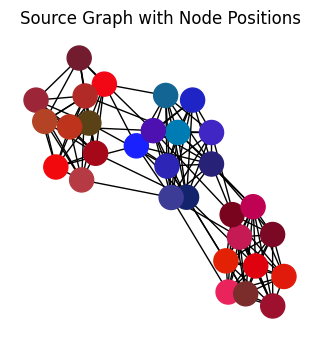

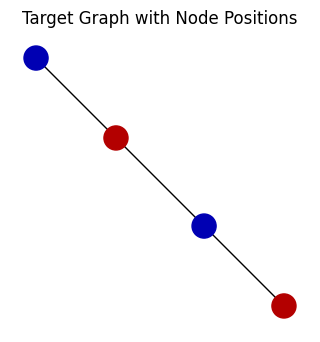

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Total transported mass : tensor(0.7849)


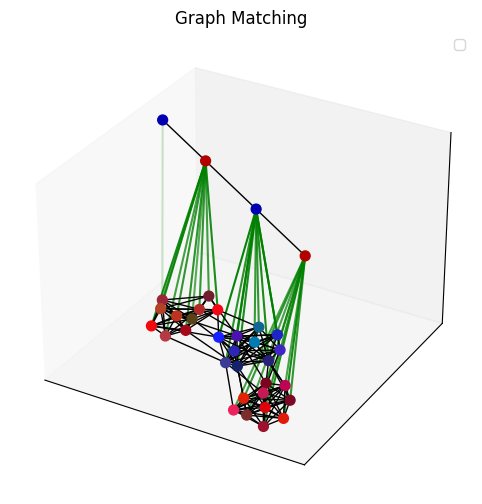

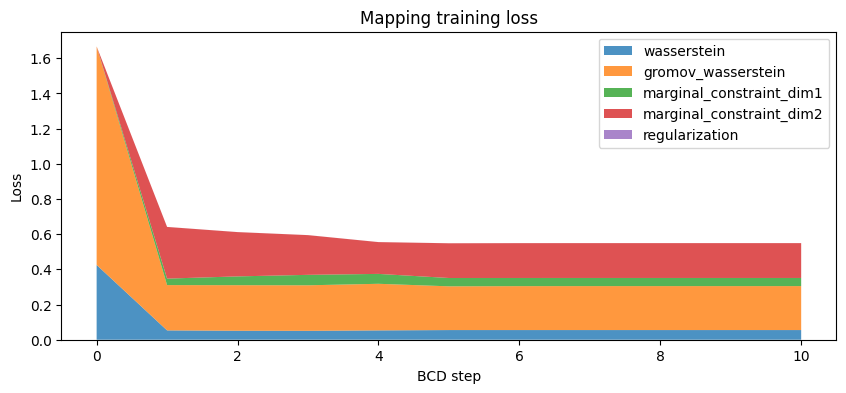

In [90]:
import numpy as np
import matplotlib.pylab as pl
from ot.gromov import entropic_semirelaxed_gromov_wasserstein, entropic_semirelaxed_fused_gromov_wasserstein, gromov_wasserstein, fused_gromov_wasserstein
import networkx as nx
from networkx.generators.community import stochastic_block_model as sbm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from fugw_solver.solver import solver
import torch
from collections import defaultdict
import math

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

def plt_scatter(locations, colours):
    x = []
    y = []
    for value in locations.values():
        x.append(value[0])
        y.append(value[1])
    plt.scatter(x,y,c=colours)
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.show()

def angle(vector1, vector2):
    """ Returns the angle in radians between given vectors"""
    v1_u = unit_vector(vector1)
    v2_u = unit_vector(vector2)
    minor = np.linalg.det(
        np.stack((v1_u[-2:], v2_u[-2:]))
    )
    if minor == 0:
        raise NotImplementedError('Too odd vectors =(')
    return -np.sign(minor) * np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def unit_vector(vector):
    """ Returns the unit vector of the vector"""
    return vector / np.linalg.norm(vector)


###CREATE GRAPHS

N3 = 30  # 3 communities
p3 = [[1., 0.1, 0.],
      [0.1, 0.95, 0.1],
      [0., 0.1, 0.9]]
G3 = sbm(seed=0, sizes=[N3 // 3, N3 // 3, N3 // 3], p=p3)
C3 = nx.to_numpy_array(G3)
h3 = np.ones(C3.shape[0]) / C3.shape[0]
weight_intra_G3 = 1.
weight_inter_G3 = 1.5

source_graph = nx.Graph()
part_G3 = [G3.nodes[i]['block'] for i in range(N3)]

source_node_colors = {}
for i in range(len(part_G3)):
    if part_G3[i] == 0:
        source_node_colors[i] = (min(0.7 + 0.2 * np.random.randn(), 1), abs(0.2 * np.random.randn()), abs(0.2 * np.random.randn()))
    elif part_G3[i] == 1:
        source_node_colors[i] = (abs(0.2 * np.random.randn()), abs(0.2 * np.random.randn()), min(0.2 * np.random.randn() + 0.7, 1))
    else:
        source_node_colors[i] = (min(0.7 + 0.2 * np.random.randn(), 1), abs(0.2 * np.random.randn()), abs(0.2 * np.random.randn()))
        
source_features = list(source_node_colors.values())

nx.set_node_attributes(source_graph, source_node_colors, 'color')
source_node_colors = nx.get_node_attributes(source_graph, 'color').values()

for node in G3.nodes():
    source_graph.add_node(node)
for i, j in G3.edges():
    if part_G3[i] == part_G3[j]:
        source_graph.add_edge(i, j, weight=weight_intra_G3)
    else:
        source_graph.add_edge(i, j, weight=weight_inter_G3)

source_geometry = nx.floyd_warshall_numpy(source_graph)

source_locations = nx.spring_layout(source_graph)

mean_cluster_1 = np.mean(list(source_locations.values())[:10], axis=0)
mean_cluster_3 = np.mean(list(source_locations.values())[-10:], axis=0)

direction_source = mean_cluster_3 - mean_cluster_1

target_adjacency_matrix = np.array([[0, 1, 0, 0], [1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0]])

target_graph = nx.Graph(target_adjacency_matrix)

target_features = [(0.7, 0, 0), (0, 0, 0.7), (0.7, 0, 0), (0, 0, 0.7)]

target_node_colors = {i:target_features[i] for i in range(len(target_features))}

nx.set_node_attributes(target_graph, target_node_colors, 'color')
target_node_colors = nx.get_node_attributes(target_graph, 'color').values()

target_geometry = nx.floyd_warshall_numpy(target_graph) * 6

target_locations = nx.spring_layout(target_graph)

direction_target = list(target_locations.values())[-1] - list(target_locations.values())[0]

theta = angle(direction_source, direction_target)

origin = np.mean(list(target_locations.values()), axis=0)

for key, value in target_locations.items():
    target_locations[key] = rotate(origin, value, theta)
    




###VISUALISE GRAPHS 

plt.figure(figsize=(3, 3))
nx.draw(source_graph, source_locations, node_color=source_features, with_labels=False)
plt.title('Source Graph with Node Positions')
plt.show()

plt.figure(figsize=(3, 3))
nx.draw(target_graph, target_locations, node_color=target_features, with_labels=False)
plt.title('Target Graph with Node Positions')
plt.show()

###CREATE GEOMETRY AND FEATURES

source_features = torch.tensor(source_features, dtype=torch.float32)
target_features = torch.tensor(target_features, dtype=torch.float32)

source_features_normalized = source_features / torch.linalg.norm(source_features, dim=1).reshape(-1, 1)
target_features_normalized = target_features / torch.linalg.norm(target_features, dim=1).reshape(-1, 1)

source_features_normalized = torch.transpose(source_features_normalized, 0, 1)
target_features_normalized = torch.transpose(target_features_normalized, 0, 1)

source_geometry = torch.tensor(source_geometry, dtype=torch.float32) / 5
target_geometry = torch.tensor(target_geometry, dtype=torch.float32) / 5

w_s = torch.ones(source_features_normalized.shape[1], device='cpu') / source_features_normalized.shape[1]
w_t = torch.ones(target_features_normalized.shape[1], device='cpu') / target_features_normalized.shape[1]


###SOLVE

alpha = 0.5
rho = 0.5
eps = 1e-4
mapping = solver(alpha=alpha, rho=rho, eps=eps, 
    source_features=source_features_normalized,
    target_features=target_features_normalized,
    source_geometry=source_geometry,
    target_geometry=target_geometry,
    device='cpu',
    w_s=w_s,
    w_t=w_t
)

P = mapping[0]

print("Total transported mass :", P.sum())

###PLOT

def plot_graph_matching_3D(source_locations, target_locations, source_graph, target_graph, P, distance_between_graphs):
    pos_source = source_locations
    pos_target = target_locations

    pos_source = np.array([[pos_source[key][0], pos_source[key][1], 0] for key in pos_source.keys()])
    pos_target = np.array([[pos_target[key][0], pos_target[key][1], distance_between_graphs] for key in pos_target.keys()])
    
    edges_source = list(source_graph.edges())
    segments_source = [[pos_source[edge[0]].tolist(), pos_source[edge[1]].tolist()] for edge in edges_source]
    
    edges_target = list(target_graph.edges())
    segments_target = [[pos_target[edge[0]].tolist(), pos_target[edge[1]].tolist()] for edge in edges_target]
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')  
    
    line_segments_source = Line3DCollection(segments_source, colors="black", lw=1, zorder=1)
    ax.add_collection(line_segments_source)  
    ax.scatter(pos_source[:, 0], pos_source[:, 1], pos_source[:, 2], color=source_features.tolist(), s=50, depthshade=False)
    
    line_segments_target = Line3DCollection(segments_target, colors="black", lw=1, zorder=1)
    ax.add_collection(line_segments_target)  
    ax.scatter(pos_target[:, 0], pos_target[:, 1], pos_target[:, 2], color=target_features.tolist(), s=50, depthshade=False)

    transport_matrix = P / P.max()

    for i in range(transport_matrix.shape[0]):
        for j in range(transport_matrix.shape[1]):
            x1, y1, z1 = pos_source[i]
            x2, y2, z2 = pos_target[j]
            ax.plot([x1, x2], [y1, y2], [z1, z2], color='green', alpha=float(transport_matrix[i, j]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_title('Graph Matching')
    ax.legend()
    plt.show()

%matplotlib inline
plot_graph_matching_3D(source_locations, target_locations, source_graph, target_graph, P, 3)

loss_ls = mapping[1]
loss = defaultdict(list)
for l in loss_ls:
    for k,v in l.items():
        loss[k].append(v)

fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title("Mapping training loss")
ax.set_ylabel("Loss")
ax.set_xlabel("BCD step")
ax.stackplot(
    np.arange(len(loss_ls)),
    [
        (1 - alpha) * np.array(loss["wasserstein"]),
        alpha * np.array(loss["gromov_wasserstein"]),
        rho * np.array(loss["marginal_constraint_dim1"]),
        rho * np.array(loss["marginal_constraint_dim2"]),
        eps * np.array(loss["regularization"]),
    ],
    labels=[
        "wasserstein",
        "gromov_wasserstein",
        "marginal_constraint_dim1",
        "marginal_constraint_dim2",
        "regularization",
    ],
    alpha=0.8,
)
ax.legend()
plt.show()